
# Toy example: Piecewise linear function

## Testing the Neural Incremental Posterior Estimation

#### Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
from utils import helpers
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

In [3]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C


import utils
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

- piecewise_linear is taking 6 parameters (changing points and slopes) and outputs a three-part piecewise linear function

- piecewise_linear_seq is taking a list of either 2, 3 or 4 parameters and then outputs either a one-part. a two-part or a three-part piecewise linear function

In [4]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [5]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



## **Summary statistics**

definition of summary statistics for the piecewise linear function

In [6]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(10) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = np.nanargmin(batch[x<4])   #value of min
    

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = np.nanmin(batch[(x>=4)&(x<8)])
            s[5] = np.nanargmin(batch[(x>=4)&(x<8)])

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[6] = np.nanmin(batch[x>=5])
            s[7] = np.nanargmin(batch[x>=5])
            
            s[8] = np.nanmax(batch[x>=5])
            s[9] = np.nanargmax(batch[x>=5])
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## Sequential Time Series SBI


We have the following parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [7]:
#parameter a1,b,a2,a3, cp1, cp2


prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [9]:
### first round:
from sbi import utils as utils

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])


inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
x = extract_sumstats(x_without)

In [11]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 56 epochs.


In [12]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


In [13]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])


In [31]:
#samples_0 = torch.stack(samples_0)
print(samples_0)
data = torch.from_numpy(data)

tensor([6.0055, 5.3935, 6.5335, 6.6106, 5.8397, 5.2735, 5.6029, 5.5786, 5.5187,
        5.8772, 5.3861, 5.2574, 5.5486, 5.1428, 5.2889, 5.1467, 5.3895, 5.3386,
        5.2842, 5.0828, 6.0661, 5.8208, 5.4688, 5.3304, 5.5156, 5.4474, 5.2992,
        6.1310, 5.1380, 5.8842, 5.4304, 5.0998, 4.4503, 6.0247, 5.9155, 5.2051,
        5.7255, 5.3164, 5.8419, 5.9809, 4.3074, 5.4835, 5.8996, 4.7596, 4.4386,
        5.4724, 5.3052, 5.4990, 4.7671, 6.0416, 5.3419, 5.2366, 5.1976, 5.9826,
        4.8006, 5.3674, 5.2010, 5.2442, 4.8746, 5.0461, 5.3343, 5.5236, 5.0301,
        5.2418, 6.1991, 5.2865, 5.3591, 6.1111, 5.4285, 5.2210, 5.2494, 5.3733,
        6.1025, 5.3718, 5.2401, 5.5780, 6.0953, 4.8187, 5.4874, 5.2213, 5.9700,
        5.7704, 6.1347, 5.3863, 4.0980, 5.0344, 5.3193, 6.5538, 5.8765, 5.4711,
        5.9704, 5.3106, 5.2260, 5.0272, 4.2535, 5.1303, 5.1777, 5.9300, 5.6390,
        5.1920, 5.2062, 4.1463, 6.0439, 5.5146, 3.9529, 6.0807, 4.8311, 5.6095,
        6.2138, 5.2031, 5.3376, 5.3378, 

In [35]:
data

tensor([6.4205, 3.1265, 5.3481, 5.8818, 4.4260, 3.2440, 3.2870, 4.5329, 5.1785,
        4.4802, 4.1738, 5.7229, 5.9150, 6.8718, 5.6362, 5.4085, 4.5826, 5.6459,
        4.7665, 3.2222, 3.5404, 5.0800, 5.8686, 3.8972, 5.2277, 6.9691, 3.6217,
        6.9207, 3.0097, 3.7443, 6.3323, 3.3040, 4.1394, 3.1509, 5.6208, 5.1251,
        4.4471, 6.1741, 6.1260, 4.6861, 6.4279, 6.6763, 3.8939, 4.1975, 4.7096,
        5.9103, 5.8703, 4.8350, 6.5322, 6.7104, 3.7252, 4.0065, 3.9108, 6.3807,
        6.8901, 5.7757, 5.8152, 5.9589, 4.1900, 3.4911, 4.7473, 4.0820, 4.8218,
        3.7495, 3.4374, 5.6679, 5.1406, 4.5587, 4.8975, 3.2782, 6.3609, 6.5775,
        5.1007, 4.4594, 5.9949, 3.5537, 3.4669, 4.9861, 5.9879, 5.4442, 6.7247,
        5.3242, 3.5068, 6.0850, 6.6882, 4.0726, 3.1242, 5.0692, 6.6353, 5.8416,
        3.3832, 4.4085, 4.7098, 6.7893, 5.3036, 6.6802, 3.6046, 6.0844, 5.9195,
        6.7878], dtype=torch.float64)

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.0277592 , 0.        , 0.01850613, ..., 0.03701227, 0.0277592 ,
         0.00925307],
        [0.0277592 , 0.        , 0.01850613, ..., 0.03701227, 0.0277592 ,
         0.00925307],
        [0.0277592 , 0.        , 0.01850613, ..., 0.03701227, 0.0277592 ,
         0.00925307]]),
 array([3.29488564, 3.40295792, 3.5110302 , 3.61910248, 3.72717476,
        3.83524704, 3.94331932, 4.0513916 , 4.15946388, 4.26753616,
        4.37560844, 4.48368073, 4.59175301, 4.69982529, 4.80789757,
        4.91596985, 5.02404213, 5.13211441, 5.24018669, 5.34825897,
        5.45633125, 5.56440353, 5.67247581, 5.7805481 , 5.88862038,
        5.99669266, 6.10476494, 6.21283722, 6.3209095 , 6.42898178,
 

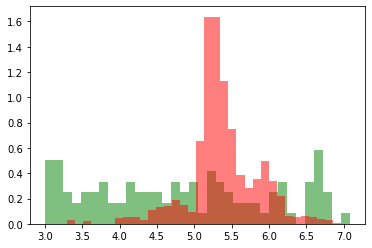

In [39]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.


binsteps1 = np.abs(max(data)-min(data))*0.03 + 0.001

binrange1 = np.arange(min(data), max(data) + binsteps1, binsteps1)

binsteps2 = np.abs(max(samples_0)-min(samples_0))*0.03 + 0.001

binrange2 = np.arange(min(samples_0), max(samples_0) + binsteps2, binsteps2)

plt.hist(data, bins=binrange1, facecolor='green',  density=True, histtype='barstacked', alpha=0.5) 
plt.hist(samples_0, bins=binrange2, facecolor='red',  density=True, histtype='barstacked', alpha=0.5)




In [32]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
3.8540637


In [33]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [41]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([-3.2433])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 66 epochs.


In [43]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

## Third and last round

In [44]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[3:4], high = prior_max[3:4])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([-0.8008])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [45]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 58 epochs.


In [46]:

true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

print(obs_real_stats)


samples = posterior3.sample((num_samples,), x=obs_real_stats)


prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

tensor([  4.9738,   4.9738,   0.0000,  16.8416,  11.2115, 199.0000,  11.2115,
         99.0000,  19.3366, 499.0000])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
end = get_time()


print('start:', start, '\nend:', end)

start: 02-10-2022_16:27:00 
end: 02-10-2022_17:23:35


In [48]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [49]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



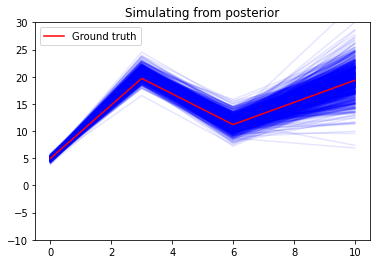

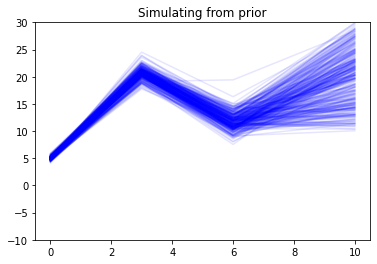

In [50]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

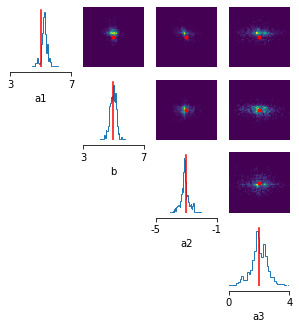

In [51]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

### Validating summary statistics with histogram plots

We should see that posterior is restricting the area of values

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


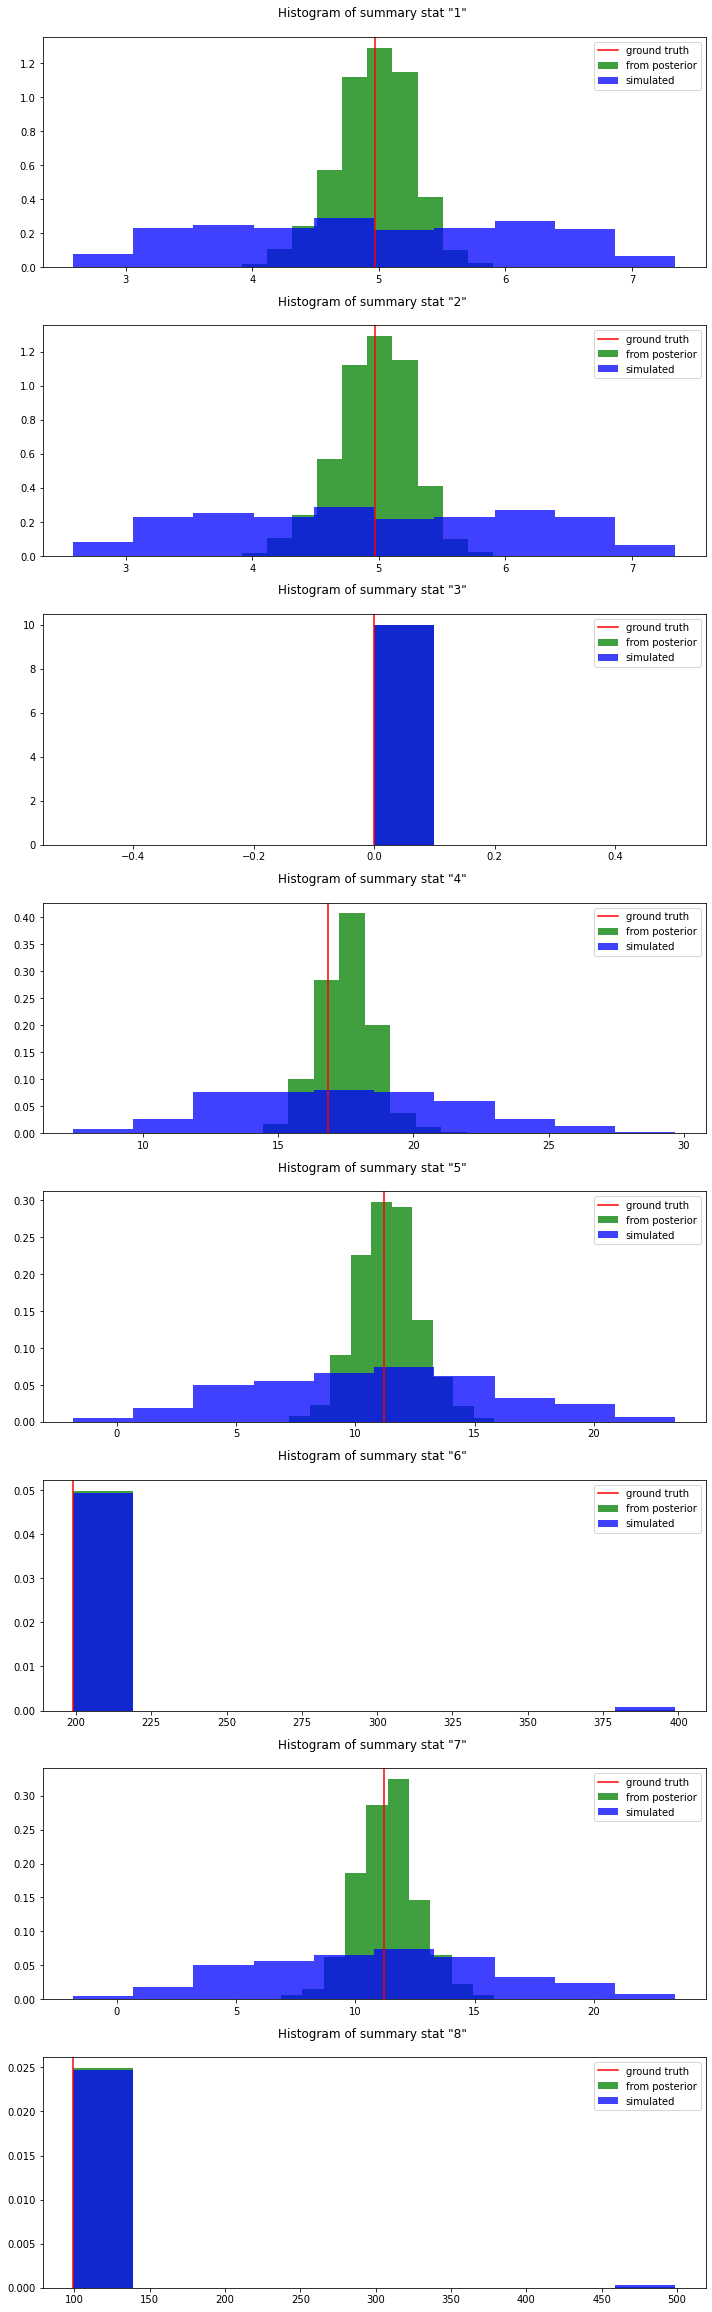

In [52]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')